# **Import Libraries**

In [61]:
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
df.shape

(416809, 3)

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
n_classes = df['label'].nunique()
n_classes

6

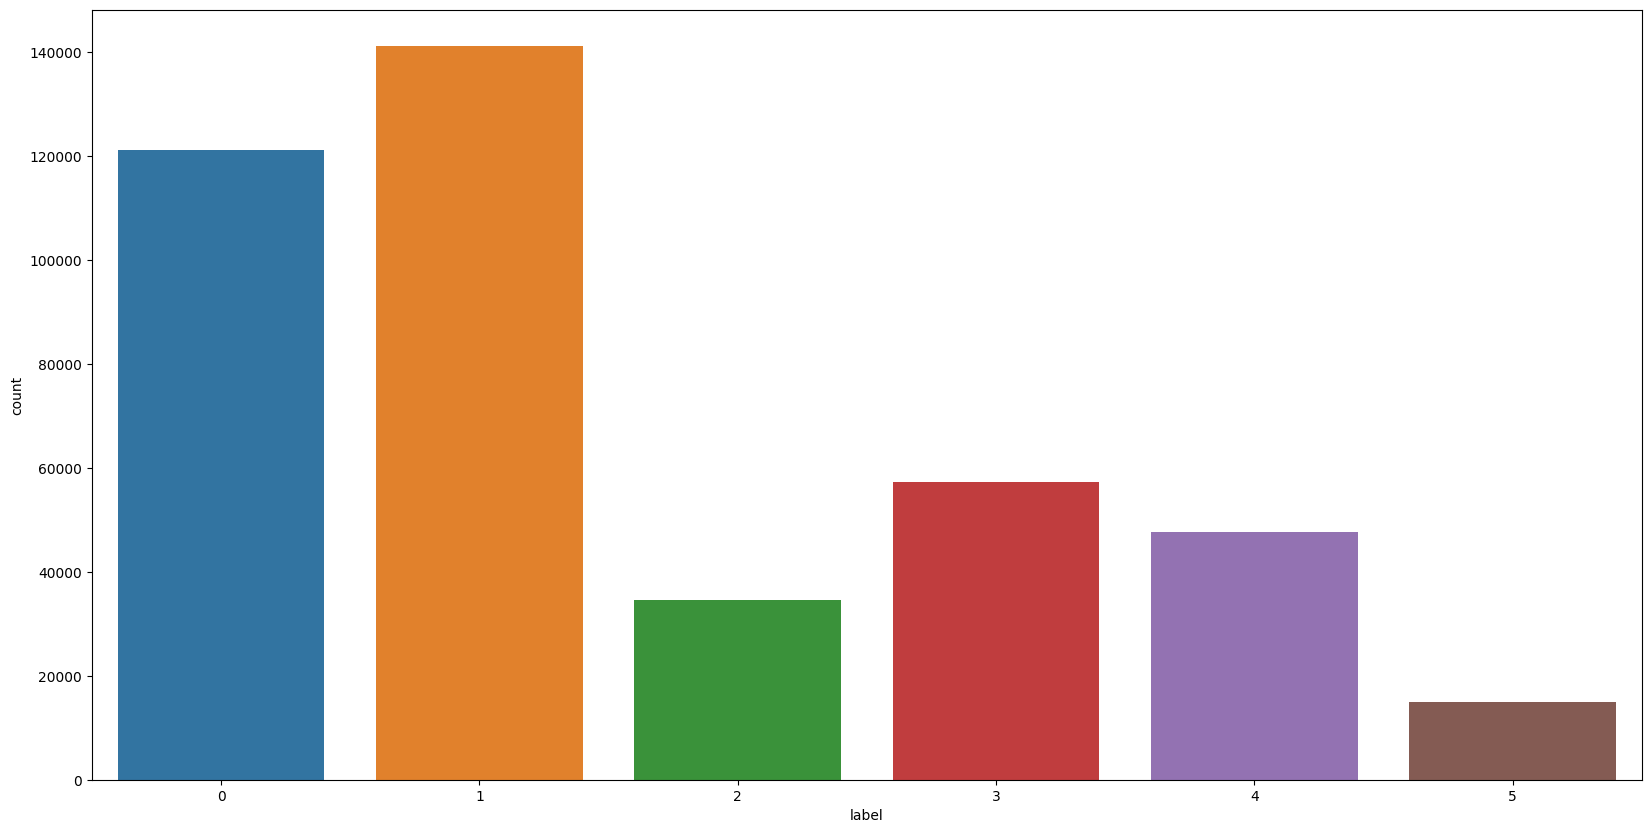

In [7]:
plt.figure(figsize=(20,10))
sns.countplot(data=df,x='label')
plt.show()

# **Preprocessing**

In [8]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>') 
    return pattern.sub('', text)

df['text'] = df['text'].apply(remove_html_tags)

In [9]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+') 
    return pattern.sub('', text)

df['text'] = df['text'].apply(remove_url)

In [10]:
def remove_digits(text):
    return re.sub(r'\d+','', text) 
df['text'] = df['text'].apply(remove_digits)

In [11]:
import string
exclude = string.punctuation
exclude

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
def remove_punc (text):
    for char in exclude:
        text = text.replace(char,'')
    return text
df['text']=df['text'].apply(remove_punc)

In [13]:
from nltk.corpus import stopwords
import nltk
StopWords = stopwords.words("english")

In [14]:
def remove_stopwords (text):
    filtered_text = ' '.join(word for word in text.split() if word.lower() not in StopWords)
    return filtered_text 

df['text']=df['text'].apply(remove_stopwords)

In [15]:
df['text'] = df['text'].str.lower()
df.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


In [16]:
vocab_sz = 10000  #==> ensure that the model focuses on the most frequent words
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(df['text'])

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train,y_test = train_test_split(df['text'],df['label'],test_size=0.2,random_state=42)

In [19]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (333447,)
X_test shape: (83362,)
y_train shape: (333447,)
y_test shape: (83362,)


**Convert texts to sequences of intgers**

In [20]:
x_train_seq = tok.texts_to_sequences(x_train)
x_test_seq = tok.texts_to_sequences(x_test)

In [21]:
# Max Len in X_train_sequences
maxlen = max(len(tokens) for tokens in x_train_seq)
print("Maximum sequence length:", maxlen)

Maximum sequence length: 79


In [29]:
x_train_padded = pad_sequences(x_train_seq, maxlen=maxlen, padding='post',)
x_test_padded = pad_sequences(x_test_seq, maxlen=maxlen, padding='post')

In [31]:
print("First padded training sequence:", x_train_padded[0])
print("First padded testing sequence:", x_test_padded[0])

First padded training sequence: [ 17   1  70 485   5 184  17   3  35 482   1 994   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
First padded testing sequence: [ 121   40  170   52    2  565   12    1 2303    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


# **LSTM**

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

embedding_size = 100

# Model: Enhanced LSTM with multiple layers
model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

# Add the first LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next LSTM layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a second LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a third LSTM layer
model.add(LSTM(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a fully connected layer
model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for dense layer

# Output layer
model.add(Dense(n_classes, activation='softmax'))  # For classification

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
checkpoint = EarlyStopping(monitor='val_accuracy',patience = 10 ,mode='max')
callbacks_lst = [checkpoint]

In [52]:
batch_size = 1500
epochs = 10
history = model.fit(x_train_padded, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,callbacks=callbacks_lst)

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 90s 468ms/step - accuracy: 0.6024 - loss: 1.0764 - val_accuracy: 0.8132 - val_loss: 1.0428
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 462ms/step - accuracy: 0.9125 - loss: 0.2425 - val_accuracy: 0.9278 - val_loss: 0.2294
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 463ms/step - accuracy: 0.9338 - loss: 0.1562 - val_accuracy: 0.9296 - val_loss: 0.1248
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 83s 466ms/step - accuracy: 0.9388 - loss: 0.1296 - val_accuracy: 0.9321 - val_loss: 0.1170
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 83s 465ms/step - accuracy: 0.9417 - loss: 0.1151 - val_accuracy: 0.9314 - val_loss: 0.1081
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 84s 470ms/step - accuracy: 0.9437 - loss: 0.1065 - val_accuracy: 0.9320 - val_loss: 0.1053
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 83s 466ms/step - accuracy: 0.9433 - loss: 0.1030 - val_accuracy: 0.9341 - val_loss: 0.1016
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 83s 467ms/step - accuracy: 0.9438 - loss: 0

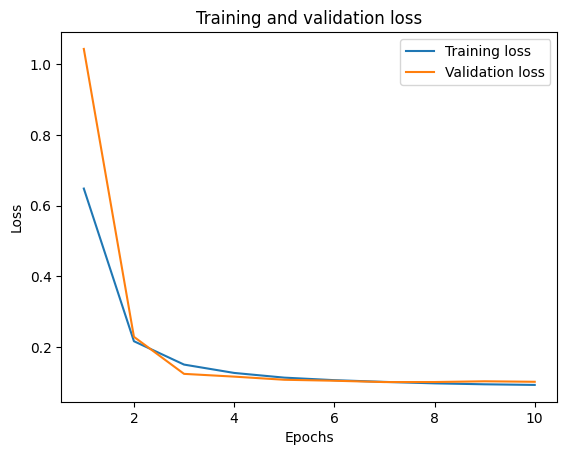

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

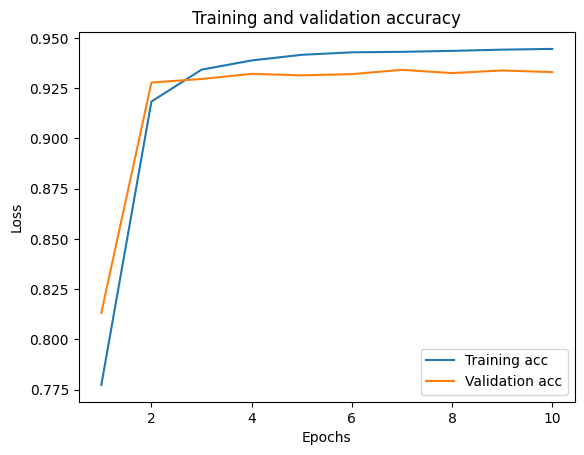

In [54]:
plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [55]:
model.evaluate(x_test_padded,y_test)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 195s 75ms/step - accuracy: 0.9336 - loss: 0.1021


[0.10192325711250305, 0.9335788488388062]

In [56]:
model.evaluate(x_train_padded,y_train)

10421/10421 ━━━━━━━━━━━━━━━━━━━━ 774s 74ms/step - accuracy: 0.9473 - loss: 0.0810


[0.0843612402677536, 0.9449927806854248]

In [57]:
y_pred = model.predict(x_test_padded).argmax(axis=-1)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 191s 73ms/step


In [58]:
from sklearn.metrics  import classification_report ,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     24201
           1       0.97      0.93      0.95     28164
           2       0.78      0.95      0.85      6929
           3       0.92      0.97      0.94     11441
           4       0.95      0.83      0.89      9594
           5       0.76      0.83      0.79      3033

    accuracy                           0.93     83362
   macro avg       0.89      0.91      0.90     83362
weighted avg       0.94      0.93      0.93     83362



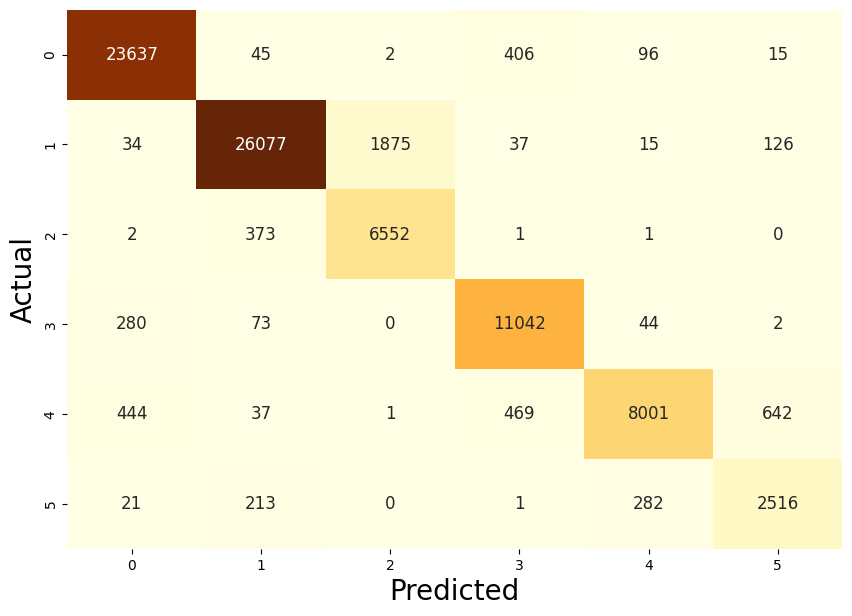

In [59]:
disp = confusion_matrix(y_test, y_pred)
disp.astype('int')
df_cm = pd.DataFrame(disp)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size":12},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.show()

# **RNN**

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.layers import Embedding
from keras.layers import SimpleRNN

embedding_size = 100

# Model: Enhanced RNN with multiple layers
model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

# Add the first RNN layer
model.add(SimpleRNN(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next RNN layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a second RNN layer
model.add(SimpleRNN(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a third RNN layer
model.add(SimpleRNN(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a fully connected layer
model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for dense layer

# Output layer
model.add(Dense(n_classes, activation='softmax'))  # For classification

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
batch_size = 1500
epochs = 20
history = model.fit(x_train_padded, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,callbacks=callbacks_lst)

Epoch 1/20
  1/178 ━━━━━━━━━━━━━━━━━━━━ 49:57 17s/step - accuracy: 0.1913 - loss: 2.5946

I0000 00:00:1733944273.050385     131 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1733944273.071415     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2081 - loss: 2.1527

I0000 00:00:1733944299.938120     130 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 4 bytes spill loads



178/178 ━━━━━━━━━━━━━━━━━━━━ 46s 166ms/step - accuracy: 0.2083 - loss: 2.1514 - val_accuracy: 0.3431 - val_loss: 1.5917
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.3642 - loss: 1.5706 - val_accuracy: 0.8124 - val_loss: 0.5803
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.7807 - loss: 0.6481 - val_accuracy: 0.8584 - val_loss: 0.4208
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8381 - loss: 0.4897 - val_accuracy: 0.8636 - val_loss: 0.3955
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8541 - loss: 0.4359 - val_accuracy: 0.8677 - val_loss: 0.3901
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.8570 - loss: 0.4239 - val_accuracy: 0.8819 - val_loss: 0.3497
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.8724 - loss: 0.3838 - val_accuracy: 0.8911 - val_loss: 0.3224
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.8779 - loss: 0.3662 - val_accura

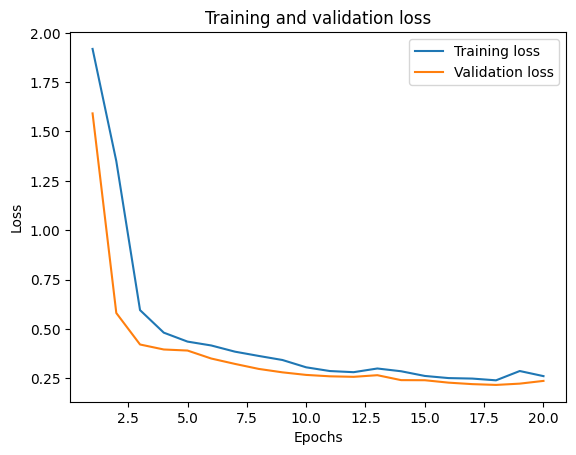

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

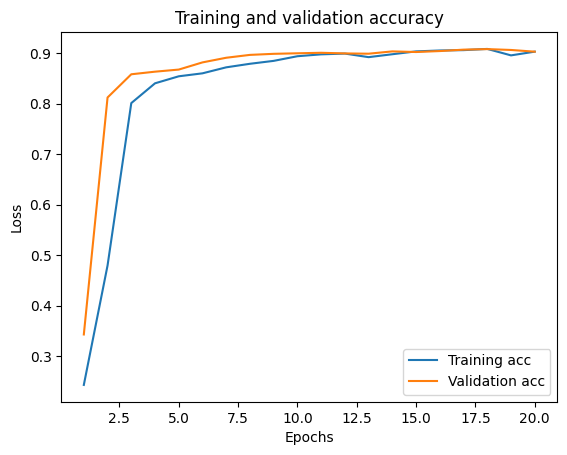

In [37]:
plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
model.evaluate(x_test_padded,y_test)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9020 - loss: 0.2380


[0.23770083487033844, 0.9020057320594788]

In [42]:
model.evaluate(x_train_padded,y_train)

10421/10421 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.9164 - loss: 0.1987


[0.20441186428070068, 0.9145501255989075]

In [44]:
y_pred = model.predict(x_test_padded).argmax(axis=-1)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


In [45]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     24201
           1       0.95      0.89      0.92     28164
           2       0.76      0.87      0.81      6929
           3       0.89      0.93      0.91     11441
           4       0.86      0.85      0.85      9594
           5       0.71      0.78      0.74      3033

    accuracy                           0.90     83362
   macro avg       0.85      0.88      0.86     83362
weighted avg       0.91      0.90      0.90     83362



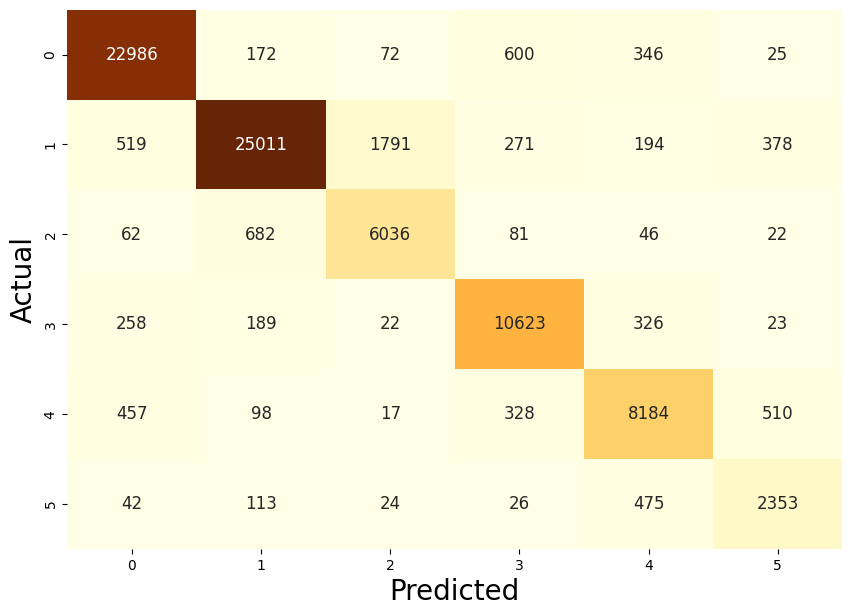

In [46]:
disp = confusion_matrix(y_test, y_pred)
disp.astype('int')
df_cm = pd.DataFrame(disp)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size":12},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.show()